In [1]:
import pandas as pd
import numpy as np
import math
import time

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt

import constant
import tools

# 1. Load Files

In [2]:
settlement = pd.read_parquet(constant.settlement_2019_one_path)

windmill = pd.read_csv(constant.windmill_one_path)

wu10 = pd.read_parquet(constant.wu10_path)
wv10 = pd.read_parquet(constant.wv10_path)
wu100 = pd.read_parquet(constant.wu100_path)
wv100 = pd.read_parquet(constant.wv100_path)
ws10 = pd.read_parquet(constant.ws10_path)
ws100 = pd.read_parquet(constant.ws100_path)

tmp2 = pd.read_parquet(constant.tmp2_path)
tmp100 = pd.read_parquet(constant.tmp100_path)

In [3]:
settlement["GSRN"] = settlement["GSRN"].astype(str)
windmill["GSRN"] = windmill["GSRN"].astype(str)
windmill["grid"] = windmill["grid"].astype(str)

### Aggregate windmill and settlement

In [4]:
df = pd.merge(windmill, settlement, on="GSRN")

# 2. Feature Extraction
## Extract Weather Data
Register grided weather data extration functions

In [5]:
get_by_grid = lambda df, g, t: df[df['TIME'] == t][g].tolist()[0] 

get_by_grid_wu10 = lambda g, t: get_by_grid(wu10, g, t)
get_by_grid_wv10 = lambda g, t: get_by_grid(wv10, g, t)
get_by_grid_wu100 = lambda g, t: get_by_grid(wu100, g, t)
get_by_grid_wv100 = lambda g, t: get_by_grid(wv100, g, t)
get_by_grid_ws10 = lambda g, t: get_by_grid(ws10, g, t)
get_by_grid_ws100 = lambda g, t: get_by_grid(ws100, g, t)
get_by_grid_tmp2 = lambda g, t: get_by_grid(tmp2, g, t)
get_by_grid_tmp100 = lambda g, t: get_by_grid(tmp100, g, t)

def get_weather(x, fun):
    try:
        return fun(x["grid"], x["TIME_CET"])
    except:
        return 0

Extract weather data

In [6]:
start = time.time()

df["wu10"] = df.apply(lambda x: get_weather(x, get_by_grid_wu10), axis=1)
df["wv10"] = df.apply(lambda x: get_weather(x, get_by_grid_wv10), axis=1)
df["wu100"] = df.apply(lambda x: get_weather(x, get_by_grid_wu100), axis=1)
df["wv100"] = df.apply(lambda x: get_weather(x, get_by_grid_wv100), axis=1)
df["ws10"] = df.apply(lambda x: get_weather(x, get_by_grid_ws10), axis=1)
df["ws100"] = df.apply(lambda x: get_weather(x, get_by_grid_ws100), axis=1)
df["tmp2"] = df.apply(lambda x: get_weather(x, get_by_grid_tmp2), axis=1)
df["tmp100"] = df.apply(lambda x: get_weather(x, get_by_grid_tmp100), axis=1)

end = time.time()
print(end - start)

77.03499817848206


## Extract Windshear
Extract Windshear in reverse by two layers 10m, 100m

In [7]:
from math import log
def windshear(v1, v2, z1, z2):
    """
    Calaulate windshear in reverse by two layers
    """
    a1 = abs(v1)
    a2 = abs(v2)
    if v1 < 0 and v2 >= 0 or v1 >= 0 and v2 < 0:
        a2 = a1 + a2

    a = log(a2/(a1+1e-06)+1e-06) / log(z2/z1)

    return a

"wsr_u": wind shear from wind_u_10m, wind_u_100m    
"wsr_v": wind shear from wind_v_10m, wind_v_100m    
"wsr": wind shear from wind_speed_10m, wind_speed_100m

In [8]:
df["wsr_u"] = df.apply(lambda x: windshear(x["wu10"], x["wu100"], 10, 100), axis=1)
df["wsr_v"] = df.apply(lambda x: windshear(x["wv10"], x["wv100"], 10, 100), axis=1)
df["wsr"] = df.apply(lambda x: windshear(x["ws10"], x["ws100"], 10, 100), axis=1)

## Interpolation Wind Speed to Hub height
by power law

In [9]:
pow_law = lambda v, z, z_hat, a : v * ( (z_hat/z) ** a) + 1e-06

In [10]:
get_ws_hub_r_u = lambda x,fun :fun(x["wu10"], 10, x["Navhub_height"], x["Roughness"])
get_ws_hub_r_v = lambda x,fun :fun(x["wv10"], 10, x["Navhub_height"], x["Roughness"])
get_ws_hub_wsr_u = lambda x,fun :pow_law(x["wu10"], 10, x["Navhub_height"], x["wsr_u"])
get_ws_hub_wsr_v = lambda x,fun :pow_law(x["wv10"], 10, x["Navhub_height"], x["wsr_v"])

get_ws_hub_r = lambda x,fun :pow_law(x["ws10"], 10, x["Navhub_height"], x["Roughness"])
get_ws_hub_wsr = lambda x,fun :pow_law(x["ws10"], 10, x["Navhub_height"], x["wsr"])

get_ws_by_uv = lambda u, v : (u ** 2 + v ** 2) ** 0.5

### Use roughness as wind shear    
"hws_u_by_roughness" : Hubheight wind_u by roughness    
"hws_v_by_roughness" : Hubheight wind_u by roughness    
"hws_by_roughness" : Hubheight wind_speed by roughness    
"hws_by_uv_roughness" : Hubheight wind_speed by combinated u,v


In [11]:
df["hws_u_by_roughness"] = df.apply(lambda x: get_ws_hub_r_u(x, pow_law), axis=1)
df["hws_v_by_roughness"] = df.apply(lambda x: get_ws_hub_r_v(x, pow_law), axis=1)
df["hws_by_roughness"] = df.apply(lambda x: get_ws_hub_r(x, pow_law), axis=1)
df["hws_by_uv_roughness"] = df.apply(lambda x: get_ws_by_uv(x["hws_u_by_roughness"], x["hws_v_by_roughness"]), axis=1)

### Use wind shear calculated above
"hws_u_by_windshear" : Hubheight wind_u by wind shear    
"hws_v_by_windshear" : Hubheight wind_u by wind shear    
"hws_by_windshear" : Hubheight wind_speed by wind shear    
"hws_by_uv_windshear" : Hubheight wind_speed by combinated u,v

In [12]:
df["hws_u_by_windshear"] = df.apply(lambda x: get_ws_hub_wsr_u(x, pow_law), axis=1)
df["hws_v_by_windshear"] = df.apply(lambda x: get_ws_hub_wsr_v(x, pow_law), axis=1)
df["hws_by_windshear"] = df.apply(lambda x: get_ws_hub_wsr(x, pow_law), axis=1)
df["hws_by_uv_windshear"] = df.apply(lambda x: get_ws_by_uv(x["hws_u_by_windshear"], x["hws_v_by_windshear"]), axis=1)

### Quadratic and Cubic hubheight wind speed

In [13]:
df["hws_by_uv_roughness_^2"] = df.apply(lambda x: x["hws_by_uv_roughness"] ** 2 , axis=1)
df["hws_by_uv_roughness_^3"] = df.apply(lambda x: x["hws_by_uv_roughness"] ** 3 , axis=1)

df["hws_by_roughness_^2"] = df.apply(lambda x: x["hws_by_roughness"] ** 2 , axis=1)
df["hws_by_roughness_^3"] = df.apply(lambda x: x["hws_by_roughness"] ** 3 , axis=1)

df["hws_by_windshear_^2"] = df.apply(lambda x: x["hws_by_windshear"] ** 2 , axis=1)
df["hws_by_windshear_^3"] = df.apply(lambda x: x["hws_by_windshear"] ** 3 , axis=1)

df["hws_by_windshear_^2"] = df.apply(lambda x: x["hws_by_roughness"] ** 2 , axis=1)
df["hws_by_windshear_^3"] = df.apply(lambda x: x["hws_by_roughness"] ** 3 , axis=1)

## Extract max, min, mean wind speed in 3 hours

In [14]:
ls_1, ls_2, ls_3 = np.zeros(len(df)), np.zeros(len(df)), np.zeros(len(df))
m_1, m_2, m_3 = 0, 0, 0
t = []
for index, row in df.iterrows():
    t.append(row['hws_by_uv_windshear'])
    if (index + 1) % 3 == 0:
        m_1 = sum(t) / 3
        m_2 = max(t)
        m_3 = min(t)
        t = []
        ls_1[index], ls_1[index-1], ls_1[index-2] = m_1, m_1, m_1
        ls_2[index], ls_2[index-1], ls_2[index-2] = m_2, m_2, m_2
        ls_3[index], ls_3[index-1], ls_3[index-2] = m_3, m_3, m_3

df["mean_3"] = pd.Series(ls_1)
df["max_3"] = pd.Series(ls_2)
df["min_3"] = pd.Series(ls_3)

## Extract Month, Hour

In [15]:
df["month"] = df.apply(lambda x: int(x["TIME_CET"][5:7]), axis=1)
df["hour"] = df.apply(lambda x: int(x["TIME_CET"][11:13]), axis=1)

In [16]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

transformed = lb.fit_transform(df["month"].to_list())
ohe_df = pd.DataFrame(transformed)
ohe_df.columns = ["m" + str(x) for x in range(1, 13)]
df = pd.concat([df, ohe_df], axis=1)

transformed = lb.fit_transform(df["hour"].to_list())
ohe_df = pd.DataFrame(transformed)
ohe_df.columns = ["h" + str(x) for x in range(0, 24)]
df = pd.concat([df, ohe_df], axis=1)

In [17]:
df.columns

Index(['GSRN', 'Capacity_kw', 'Rotor_diameter', 'Navhub_height', 'Slope',
       'Elevation', 'Roughness', 'grid', 'VAERDI', 'TIME_CET', 'wu10', 'wv10',
       'wu100', 'wv100', 'ws10', 'ws100', 'tmp2', 'tmp100', 'wsr_u', 'wsr_v',
       'wsr', 'hws_u_by_roughness', 'hws_v_by_roughness', 'hws_by_roughness',
       'hws_by_uv_roughness', 'hws_u_by_windshear', 'hws_v_by_windshear',
       'hws_by_windshear', 'hws_by_uv_windshear', 'hws_by_uv_roughness_^2',
       'hws_by_uv_roughness_^3', 'hws_by_roughness_^2', 'hws_by_roughness_^3',
       'hws_by_windshear_^2', 'hws_by_windshear_^3', 'mean_3', 'max_3',
       'min_3', 'month', 'hour', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7',
       'm8', 'm9', 'm10', 'm11', 'm12', 'h0', 'h1', 'h2', 'h3', 'h4', 'h5',
       'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16',
       'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23'],
      dtype='object')

In [18]:
df = df.drop(columns=['GSRN',"grid","month","hour"])

# Analysis
## Compare Roughness and Wind Shear

In [19]:
def Evaluation(df, col):
    print("MAE: ", sum(col) / len(df))
    print("MSE: ", sum(col ** 2) / len(df))
    print("RMSE: ", (sum(col ** 2) / len(df)) ** 0.5)

In [20]:
df_plt = df[["TIME_CET", "Roughness", "wsr"]]

In [21]:
df_plt["abs_windshear"] = abs(df_plt["Roughness"] - df_plt["wsr"])
Evaluation(df_plt, df_plt["abs_windshear"])

MAE:  0.15072310808217776
MSE:  0.033435247996333094
RMSE:  0.18285307762335612


## Compare Hub height Wind Speed by Roughness and by Wind Shear

In [22]:
df_plt = df[["TIME_CET", "hws_u_by_roughness", "hws_u_by_windshear", "hws_v_by_roughness", "hws_v_by_windshear", "hws_by_roughness", "hws_by_windshear"]]

In [23]:
df_plt["abs_u"] = abs(df_plt["hws_u_by_roughness"] -  df_plt["hws_u_by_windshear"])
Evaluation(df_plt, df_plt["abs_u"])

MAE:  0.7620228414941178
MSE:  0.8794663723014401
RMSE:  0.9377986843141977


In [24]:
df_plt["abs_v"] = abs(df_plt["hws_v_by_roughness"] - df_plt["hws_v_by_windshear"])
Evaluation(df_plt, df_plt["abs_v"])

MAE:  0.5362936649922919
MSE:  0.5130906261486259
RMSE:  0.7163034455791943


In [25]:
df_plt["abs_ws"] = abs(df_plt["hws_by_roughness"] - df_plt["hws_by_windshear"])
Evaluation(df_plt, df_plt["abs_ws"])

MAE:  1.0022429679941909
MSE:  1.354897652262126
RMSE:  1.1640007097343739


## Wind Speed - Windmill Power Curve

In [26]:
df_plt = df[["hws_by_windshear", "VAERDI"]].rename({"hws_by_windshear":"Wind Speed", "VAERDI":"Power"}, axis=1)

In [27]:
df_plt = df_plt.sort_values(by='Wind Speed').reset_index(drop=True)

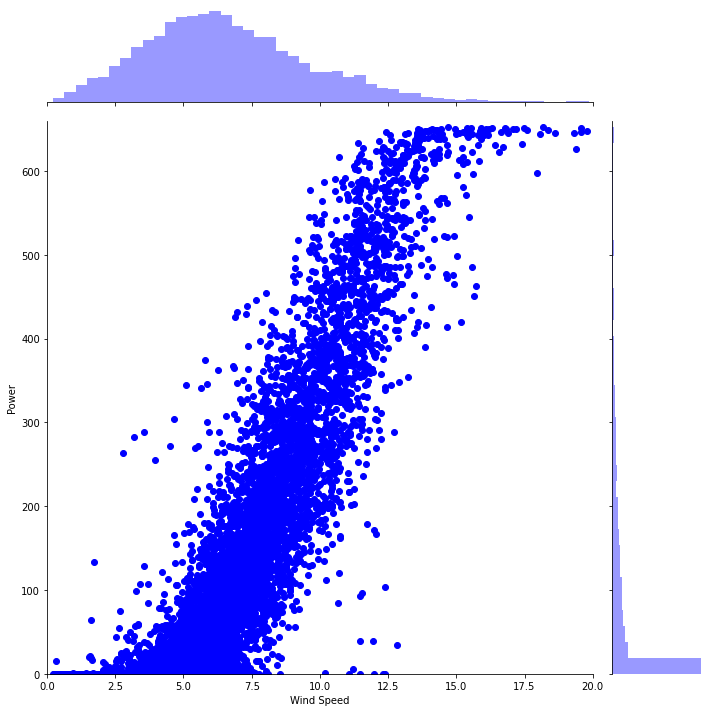

In [28]:
sns.jointplot("Wind Speed", "Power", data=df_plt, kind="scatter", xlim=(0, 20), ylim=(0, 660), color="b", height=10)

In [29]:
from sklearn.preprocessing import MinMaxScaler
df_plt = pd.DataFrame(MinMaxScaler().fit_transform(df_plt), columns=["Wind Speed", "Power"])

In [30]:
df_plt["Wind Speed"] = pd.Series(round(df_plt["Wind Speed"],1))
df_plt.groupby("Wind Speed", as_index=False)["Power"].mean()

,Wind Speed,Power
0,0.0,0.000213
1,0.1,0.002971
2,0.2,0.019851
3,0.3,0.123181
4,0.4,0.306840
5,0.5,0.543856
6,0.6,0.743579
7,0.7,0.903958
8,0.8,0.954753
9,0.9,0.981294


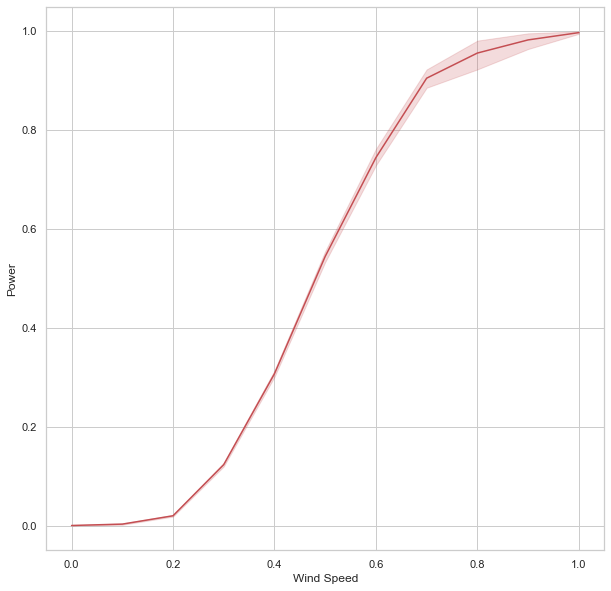

In [31]:
plt.figure(figsize=(10,10))
sns.set(style="whitegrid")
sns.lineplot(df_plt["Wind Speed"], df_plt["Power"], color="r", markers="o")

## Feature Correlation

In [32]:
df.columns

Index(['Capacity_kw', 'Rotor_diameter', 'Navhub_height', 'Slope', 'Elevation',
       'Roughness', 'VAERDI', 'TIME_CET', 'wu10', 'wv10', 'wu100', 'wv100',
       'ws10', 'ws100', 'tmp2', 'tmp100', 'wsr_u', 'wsr_v', 'wsr',
       'hws_u_by_roughness', 'hws_v_by_roughness', 'hws_by_roughness',
       'hws_by_uv_roughness', 'hws_u_by_windshear', 'hws_v_by_windshear',
       'hws_by_windshear', 'hws_by_uv_windshear', 'hws_by_uv_roughness_^2',
       'hws_by_uv_roughness_^3', 'hws_by_roughness_^2', 'hws_by_roughness_^3',
       'hws_by_windshear_^2', 'hws_by_windshear_^3', 'mean_3', 'max_3',
       'min_3', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10',
       'm11', 'm12', 'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8',
       'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18',
       'h19', 'h20', 'h21', 'h22', 'h23'],
      dtype='object')

In [33]:
cols = [x for x in df.columns if x not in ["TIME_CET","VAERDI"]]
df_corr = df[cols]

In [34]:
from sklearn.preprocessing import MinMaxScaler
df_corr = MinMaxScaler().fit_transform(df_corr)
df_corr = pd.DataFrame(df_corr, columns=cols)

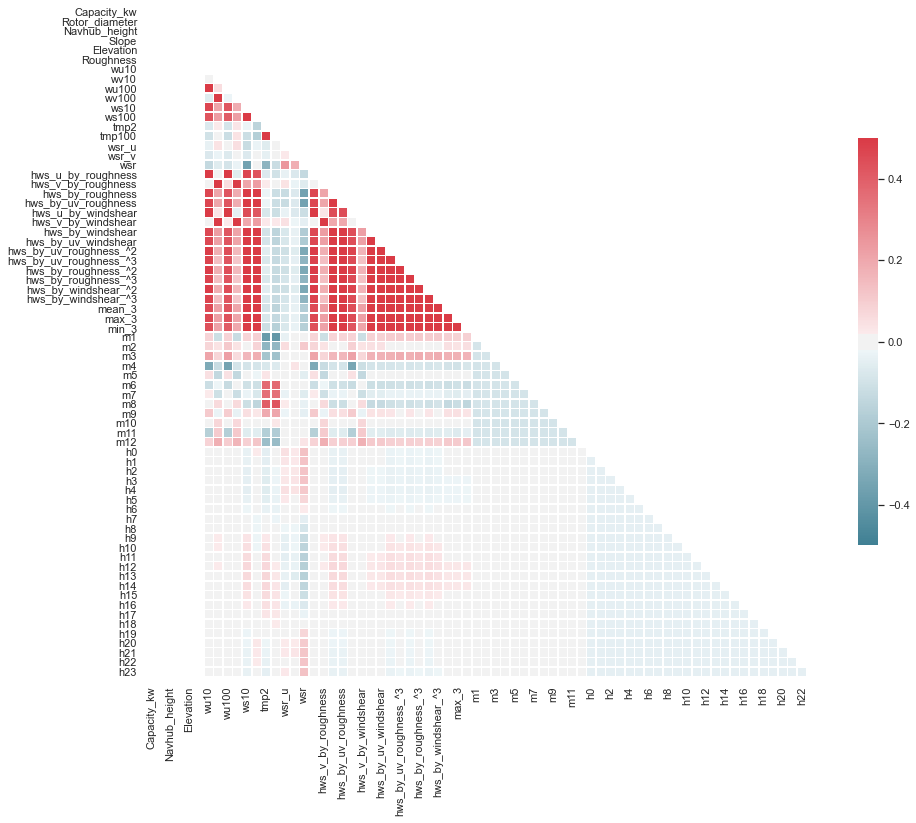

In [35]:
corr = df_corr.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(15, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.5, vmin=-0.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Prediction NN - Origin

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [85]:
class NN(nn.Module):

  def __init__(self, input_size, hidden_size, output_size):
    super(NN, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, output_size)
    self.d = nn.Dropout(p=0.1)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    # x = self.d(x)
    # x = F.relu(self.fc2(x))
    # x = self.d(x)
    x = self.fc3(x)

    return x

In [86]:
def train_model(
  model, 
  lr,
  num_epochs,
  X_train, 
  y_train, 
  X_test=None, 
  y_test=None
):
  loss_fn = torch.nn.MSELoss() # mean squared error

  optimiser = torch.optim.Adam(model.parameters(), lr=lr)
  num_epochs = num_epochs

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    y_pred = model(X_train)
    y_pred[y_pred < 0] = 0
    loss = loss_fn(y_pred.float(), y_train)

    if X_test is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        y_test_pred[y_test_pred < 0] = 0
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0 or t == num_epochs-1:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')

    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [69]:
df_copy = df.copy()

In [70]:
df = df_copy

In [71]:
# df = df.drop(df[df["VAERDI"]==0].index)

In [87]:
df["TIME_CET"] = pd.to_datetime(df["TIME_CET"])
date = pd.to_datetime("2019-12-20")
train_pd = df[df["TIME_CET"] < date]
test_pd = df[df["TIME_CET"] > date]

In [88]:
df.columns

Index(['Capacity_kw', 'Rotor_diameter', 'Navhub_height', 'Slope', 'Elevation',
       'Roughness', 'VAERDI', 'TIME_CET', 'wu10', 'wv10', 'wu100', 'wv100',
       'ws10', 'ws100', 'tmp2', 'tmp100', 'wsr_u', 'wsr_v', 'wsr',
       'hws_u_by_roughness', 'hws_v_by_roughness', 'hws_by_roughness',
       'hws_by_uv_roughness', 'hws_u_by_windshear', 'hws_v_by_windshear',
       'hws_by_windshear', 'hws_by_uv_windshear', 'hws_by_uv_roughness_^2',
       'hws_by_uv_roughness_^3', 'hws_by_roughness_^2', 'hws_by_roughness_^3',
       'hws_by_windshear_^2', 'hws_by_windshear_^3', 'mean_3', 'max_3',
       'min_3', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10',
       'm11', 'm12', 'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8',
       'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18',
       'h19', 'h20', 'h21', 'h22', 'h23'],
      dtype='object')

In [89]:
cols = ['Capacity_kw', 'Rotor_diameter', 'Navhub_height', 'tmp2', 'tmp100', 'wsr_u', 'wsr_v', 'wsr',
       'hws_u_by_windshear', 'hws_v_by_windshear',
       'hws_by_windshear', 'hws_by_uv_windshear', 
       'hws_by_windshear_^2', 'hws_by_windshear_^3', 'mean_3', 'max_3',
       'min_3', 'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8',
       'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18',
       'h19', 'h20', 'h21', 'h22', 'h23']

In [90]:
# cols = [x for x in df.columns if x not in ["TIME_CET","VAERDI"]]

In [91]:
dtype = torch.float

x_train = train_pd[cols] 
y_train = train_pd[["VAERDI"]]
x_test = test_pd[cols] 
y_test = test_pd[["VAERDI"]]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

scaler = MinMaxScaler().fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

x_train_tensor = torch.tensor(x_train, dtype = dtype)
y_train_tensor = torch.tensor(y_train, dtype = dtype)
x_test_tensor = torch.tensor(x_test, dtype = dtype)
y_test_tensor = torch.tensor(y_test, dtype = dtype)

In [92]:
model = NN(
  input_size=41,
  hidden_size=1000,
  output_size=1
)
model, train_hist, test_hist = train_model(
  model, 
  0.005,
  100,
  x_train_tensor, 
  y_train_tensor, 
  x_test_tensor, 
  y_test_tensor
)

Epoch 0 train loss: 0.08071651309728622 test loss: 0.04253518208861351
Epoch 10 train loss: 0.10395728051662445 test loss: 0.056231994181871414
Epoch 20 train loss: 0.10391119122505188 test loss: 0.056231994181871414
Epoch 30 train loss: 0.09952220320701599 test loss: 0.056231994181871414
Epoch 40 train loss: 0.017868805676698685 test loss: 0.012449057772755623
Epoch 50 train loss: 0.01723012700676918 test loss: 0.014735644683241844
Epoch 60 train loss: 0.011842513456940651 test loss: 0.009366735816001892
Epoch 70 train loss: 0.009086699225008488 test loss: 0.006609482225030661
Epoch 80 train loss: 0.008439677767455578 test loss: 0.006155223585665226
Epoch 90 train loss: 0.008325274102389812 test loss: 0.0061188992112874985
Epoch 99 train loss: 0.00824794452637434 test loss: 0.006031640339642763


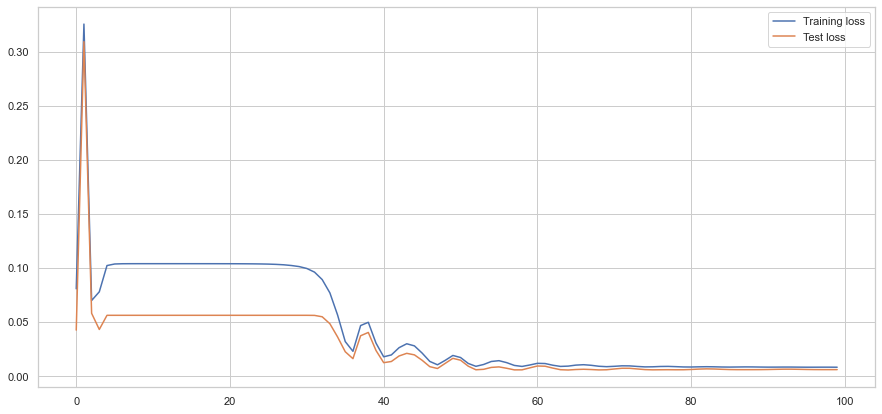

In [93]:
plt.figure(figsize=(15,7))
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend()

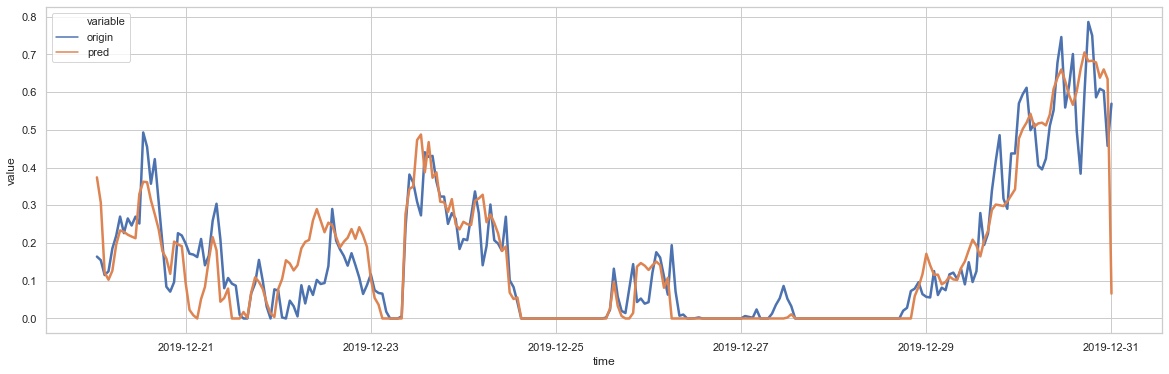

In [95]:
y_pred_tensor = model(x_test_tensor)
y_pred_tensor[y_pred_tensor < 0] = 0
y_pred = y_pred_tensor.detach().flatten().numpy()
pltdf = pd.DataFrame({"time":test_pd["TIME_CET"], "origin":y_test.flatten(), "pred":y_pred})
plt.figure(figsize=(20,6))
sns.set(style="whitegrid")
sns.lineplot(x="time",  y="value", data=pd.melt(pltdf, ['time']), hue='variable',linewidth=2.5)

### Evaluation
BIAS, MAE, MSE, RMSE

In [96]:
pltdf["bias"] = pltdf["origin"] - pltdf["pred"]
pltdf["abs"] = abs(pltdf["origin"] - pltdf["pred"])
pltdf["acu_bias"] = pltdf["bias"].cumsum()
pltdf["acu_abs"] = pltdf["abs"].cumsum()

In [97]:
pltdf = pltdf.reset_index(drop = True)
pltdf = pltdf.reset_index()
pltdf["index"] = pltdf["index"] + 1

In [98]:
pltdf["BIAS"] = pltdf["acu_bias"] / pltdf["index"] 
pltdf["MAE"] = pltdf["acu_abs"] / pltdf["index"] 
pltdf["MSE"] = (pltdf["acu_abs"] ** 2) / pltdf["index"] 
pltdf["RMSE"] = pltdf["MSE"] ** 0.5

In [99]:
pltdf["BIAS"] = pltdf["acu_bias"] / pltdf["index"] 
pltdf["MAE"] = pltdf["acu_abs"] / pltdf["index"] 
pltdf["MSE"] = (pltdf["acu_abs"] ** 2) / pltdf["index"] 
pltdf["RMSE"] = pltdf["MSE"] ** 0.5

In [100]:
pltdf

,index,time,origin,pred,bias,abs,acu_bias,acu_abs,BIAS,MAE,MSE,RMSE
0,1,2019-12-20 01:00:00,0.164060,0.374150,-0.210090,0.210090,-0.210090,0.210090,-0.210090,0.210090,0.044138,0.210090
1,2,2019-12-20 02:00:00,0.154554,0.307430,-0.152877,0.152877,-0.362967,0.362967,-0.181483,0.181483,0.065873,0.256656
2,3,2019-12-20 03:00:00,0.115149,0.121929,-0.006781,0.006781,-0.369748,0.369748,-0.123249,0.123249,0.045571,0.213474
3,4,2019-12-20 04:00:00,0.125115,0.102754,0.022361,0.022361,-0.347387,0.392108,-0.086847,0.098027,0.038437,0.196054
4,5,2019-12-20 05:00:00,0.185526,0.126508,0.059018,0.059018,-0.288369,0.451126,-0.057674,0.090225,0.040703,0.201750
...,...,...,...,...,...,...,...,...,...,...,...,...
259,260,2019-12-30 20:00:00,0.586477,0.678891,-0.092415,0.092415,-0.863691,12.004699,-0.003322,0.046172,0.554280,0.744500
260,261,2019-12-30 21:00:00,0.609169,0.638432,-0.029263,0.029263,-0.892954,12.033962,-0.003421,0.046107,0.554852,0.744884
261,262,2019-12-30 22:00:00,0.603496,0.660461,-0.056965,0.056965,-0.949919,12.090928,-0.003626,0.046149,0.557979,0.746980
262,263,2019-12-30 23:00:00,0.457528,0.634775,-0.177247,0.177247,-1.127166,12.268174,-0.004286,0.046647,0.572274,0.756488


In [101]:
cols = ["time", "BIAS",	"MAE", "MSE", "RMSE"]
pltdf_evl = pltdf[cols]

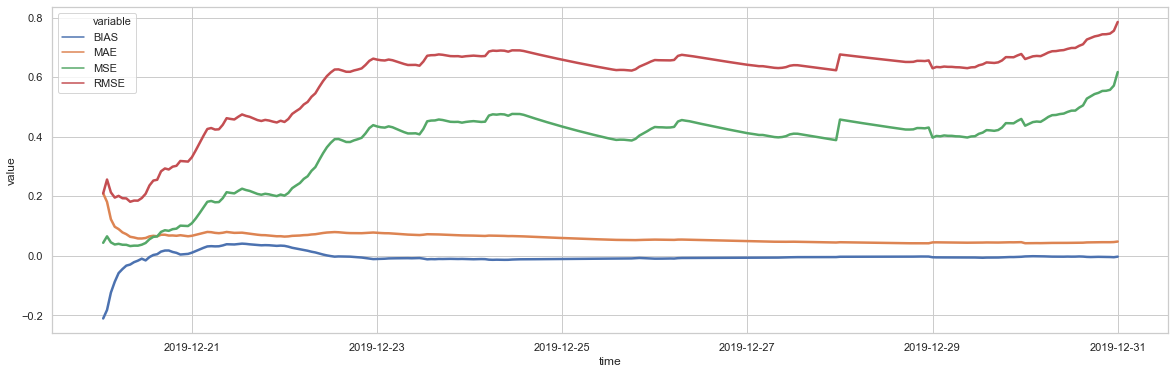

In [102]:
plt.figure(figsize=(20,6))
sns.set(style="whitegrid")
sns.lineplot(x="time",  y="value", data=pd.melt(pltdf_evl, ['time']), hue='variable',linewidth=2.5)

# Prediction NN - Geo

In [ ]:
df["TIME_CET"] = pd.to_datetime(df["TIME_CET"])
date = pd.to_datetime("2019-12-20")
train_pd = df[df["TIME_CET"] < date]
test_pd = df[df["TIME_CET"] > date]

In [ ]:
cols = ['Capacity_kw', 'Rotor_diameter', 'Navhub_height', 'Slope', 'tmp2', 'tmp100', 'wsr_u', 'wsr_v', 'wsr',
       'hws_u_by_roughness', 'hws_v_by_roughness', 'hws_by_roughness',
       'hws_by_uv_roughness',  'hws_by_uv_roughness_^2',
       'hws_by_uv_roughness_^3', 'hws_by_roughness_^2', 'hws_by_roughness_^3',
        'mean_3', 'max_3',
       'min_3',  'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8',
       'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18',
       'h19', 'h20', 'h21', 'h22', 'h23']

In [ ]:
dtype = torch.float

x_train = train_pd[cols] 
y_train = train_pd[["VAERDI"]]
x_test = test_pd[cols] 
y_test = test_pd[["VAERDI"]]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

scaler = MinMaxScaler().fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

x_train_tensor = torch.tensor(x_train, dtype = dtype)
y_train_tensor = torch.tensor(y_train, dtype = dtype)
x_test_tensor = torch.tensor(x_test, dtype = dtype)
y_test_tensor = torch.tensor(y_test, dtype = dtype)

In [ ]:
model = NN(
  input_size=44,
  hidden_size=1000,
  output_size=1
)
model, train_hist, test_hist = train_model(
  model, 
  0.005,
  100,
  x_train_tensor, 
  y_train_tensor, 
  x_test_tensor, 
  y_test_tensor
)

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend()

In [ ]:
y_pred_tensor = model(x_test_tensor)
y_pred = y_pred_tensor.detach().flatten().numpy()
pltdf = pd.DataFrame({"time":test_pd["TIME_CET"], "origin":y_test.flatten(), "pred":y_pred})
plt.figure(figsize=(20,6))
sns.set(style="whitegrid")
sns.lineplot(x="time",  y="value", data=pd.melt(pltdf, ['time']), hue='variable',linewidth=2.5)

### Evaluation

In [ ]:
pltdf["bias"] = pltdf["origin"] - pltdf["pred"]
pltdf["abs"] = abs(pltdf["origin"] - pltdf["pred"])
pltdf["acu_bias"] = pltdf["bias"].cumsum()
pltdf["acu_abs"] = pltdf["abs"].cumsum()

In [ ]:
pltdf = pltdf.reset_index(drop = True)
pltdf = pltdf.reset_index()
pltdf["index"] = pltdf["index"] + 1

In [ ]:
pltdf["BIAS"] = pltdf["acu_bias"] / pltdf["index"] 
pltdf["MAE"] = pltdf["acu_abs"] / pltdf["index"] 
pltdf["MSE"] = (pltdf["acu_abs"] ** 2) / pltdf["index"] 
pltdf["RMSE"] = pltdf["MSE"] ** 0.5

In [ ]:
cols = ["time", "BIAS",	"MAE", "MSE", "RMSE"]
pltdf_evl = pltdf[cols]

In [ ]:
plt.figure(figsize=(20,6))
sns.set(style="whitegrid")
sns.lineplot(x="time",  y="value", data=pd.melt(pltdf_evl, ['time']), hue='variable',linewidth=2.5)

# Prediction NN - PCA

In [ ]:
cols = [x for x in df.columns if x not in ["TIME_CET","VAERDI"]]

In [ ]:
from sklearn.preprocessing import MinMaxScaler
df_scaled = MinMaxScaler().fit_transform(df[cols])

In [ ]:
VAERDI = pd.DataFrame(MinMaxScaler().fit_transform(df[["VAERDI"]]), columns=["VAERDI"])

In [ ]:
from sklearn.decomposition import PCA
transformer = PCA(n_components=47)
transformer.fit(df_scaled)
ratio = transformer.explained_variance_ratio_

In [ ]:
def top_x():
        sum_v = 0
        for i, v in enumerate(ratio):
            sum_v += v
            # if features contains 95% info
            if sum_v > 0.95:
                return i + 1
        print("Set n > current n")
        return 0

top_x()

In [ ]:
transformer = PCA(n_components=35)
X_transformed = transformer.fit_transform(df_corr)
ratio = transformer.explained_variance_ratio_

df_PCA = pd.DataFrame(X_transformed)

In [ ]:
df_PCA = pd.merge(df_PCA, df[["TIME_CET"]], left_index=True, right_index=True)
df_PCA = pd.merge(df_PCA, VAERDI, left_index=True, right_index=True)


In [ ]:
df_PCA = df_PCA[df_PCA["VAERDI"] > 0]

In [ ]:
df_PCA["TIME_CET"] = pd.to_datetime(df_PCA["TIME_CET"])
date = pd.to_datetime("2019-12-20")
train_pd = df_PCA[df_PCA["TIME_CET"] < date]
test_pd = df_PCA[df_PCA["TIME_CET"] > date]

In [ ]:
df_PCA.columns

In [ ]:
cols = [x for x in df_PCA.columns if x not in ["TIME_CET","VAERDI"]]

In [ ]:
x_train = train_pd[cols] 
y_train = train_pd[["VAERDI"]]
x_test = test_pd[cols] 
y_test = test_pd[["VAERDI"]]

In [ ]:
dtype = torch.floatdtype = torch.float
x_train_tensor = torch.tensor(x_train.values, dtype = dtype)
y_train_tensor = torch.tensor(y_train.values, dtype = dtype)
x_test_tensor = torch.tensor(x_test.values, dtype = dtype)
y_test_tensor = torch.tensor(y_test.values, dtype = dtype)

In [ ]:
model = NN(
  input_size=35,
  hidden_size=1000,
  output_size=1
)
model, train_hist, test_hist = train_model(
  model, 
  0.01,
  100,
  x_train_tensor, 
  y_train_tensor, 
  x_test_tensor, 
  y_test_tensor
)

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend()

In [ ]:
y_pred_tensor = model(x_test_tensor)
y_pred = y_pred_tensor.detach().flatten().numpy()
pltdf = pd.DataFrame({"time":test_pd["TIME_CET"], "origin":y_test.values.flatten(), "pred":y_pred})
plt.figure(figsize=(20,6))
sns.set(style="whitegrid")
sns.lineplot(x="time",  y="value", data=pd.melt(pltdf, ['time']), hue='variable',linewidth=2.5)

# Prediction LSTM

In [ ]:
class LSTM_Regression(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(LSTM_Regression, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)


  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

In [ ]:
def create_sequences_x(data, seq_length):
    s = []

    for i in range(len(data)-seq_length-1):
        x = data[i:i+seq_length]
        s.append(x)

    return np.array(s)

def create_sequences_y(data, seq_length):
    s = []

    for i in range(len(data)-seq_length-1):
        x = data[i+seq_length]
        s.append(x)

    return np.array(s)


In [ ]:
def train_model(
  model, 
  lr,
  num_epochs,
  X_train, 
  y_train, 
  X_test=None, 
  y_test=None
):
  loss_fn = torch.nn.MSELoss()

  optimiser = torch.optim.Adam(model.parameters(), lr=lr)
  num_epochs = num_epochs

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    model.reset_hidden_state()
    # model.zero_grad()
    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if X_test is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0 or t == num_epochs-1:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')

    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [ ]:
cols = ['Capacity_kw', 'Rotor_diameter', 'Navhub_height', 'Slope',
       'Elevation', 'Roughness', 'wu10', 'wv10',
       'wu100', 'wv100', 'ws10', 'ws100', 'tmp2', 'tmp100', 'month', 'hour',
       'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11',
       'm12', 'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9',
       'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19',
       'h20', 'h21', 'h22', 'h23', 'wsr_u', 'wsr_v', 'wsr',
       'hws_u_by_roughness', 'hws_v_by_roughness', 'hws_u_by_windshear',
       'hws_v_by_windshear', 'hws_by_roughness', 'hws_by_windshear',
       'hws_by_uv_roughness', 'hws_by_uv_windshear', 'hws_by_uv_roughness_^2',
       'hws_by_uv_roughness_^3', 'hws_by_roughness_^2', 'hws_by_roughness_^3',
       'hws_by_windshear_^2', 'hws_by_windshear_^3']

In [ ]:
len(cols)

In [ ]:
x_train = train_pd[cols] 
y_train = train_pd[["VAERDI"]]
x_test = test_pd[cols] 
y_test = test_pd[["VAERDI"]]

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

scaler = MinMaxScaler().fit(y_train)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [ ]:
seq_length = 2
x_train = create_sequences_x(x_train, seq_length)
y_train = create_sequences_y(y_train, seq_length)
x_test = create_sequences_x(x_test, seq_length)
y_test = create_sequences_y(y_test, seq_length)

dtype = torch.float
x_train_tensor = torch.tensor(x_train, dtype = dtype)
y_train_tensor = torch.tensor(y_train, dtype = dtype)
x_test_tensor = torch.tensor(x_test, dtype = dtype)
y_test_tensor = torch.tensor(y_test, dtype = dtype)

In [ ]:
model = LSTM_Regression(
  n_features=69, 
  n_hidden=100, 
  seq_len=seq_length, 
  n_layers=2
)
model, train_hist, test_hist = train_model(
  model, 
  0.5,
  50,
  x_train_tensor, 
  y_train_tensor, 
  x_test_tensor, 
  y_test_tensor
)

In [ ]:
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend()